episodic_only
- mean 44.56
- std 1.85

semantic_only
- mean 55.72
- std 1.61

random
- mean 37.64 
- std 2.16

dqn, pretrained, no ddqn, no dueling (w/ warm_start)
- mean 108.2
- std 5.01

dqn, no ddqn, no dueling (w/ warm_start)
- mean 91.28
- std 8.43


In [2]:
from explicit_memory.utils import read_yaml
from glob import glob

test_scores = {"pre_trained": [], "not_pre_trained": []}
for foo in glob("./training_results/refactoring/dqn_warmstart/*/results.yaml"):
    results = read_yaml(foo)
    test_scores["not_pre_trained"].append(results["test_score"])

for foo in glob(
    "./training_results/refactoring/dqn_pretrained_warmstart/*/results.yaml"
):
    results = read_yaml(foo)
    test_scores["pre_trained"].append(results["test_score"])

In [3]:
import numpy as np

np.mean([foo["mean"] for foo in test_scores["pre_trained"]]), np.std(
    [foo["mean"] for foo in test_scores["pre_trained"]]
)

(108.2, 5.008792269599532)

In [4]:
np.mean([foo["mean"] for foo in test_scores["not_pre_trained"]]), np.std(
    [foo["mean"] for foo in test_scores["not_pre_trained"]]
)

(91.28, 8.433836612123812)

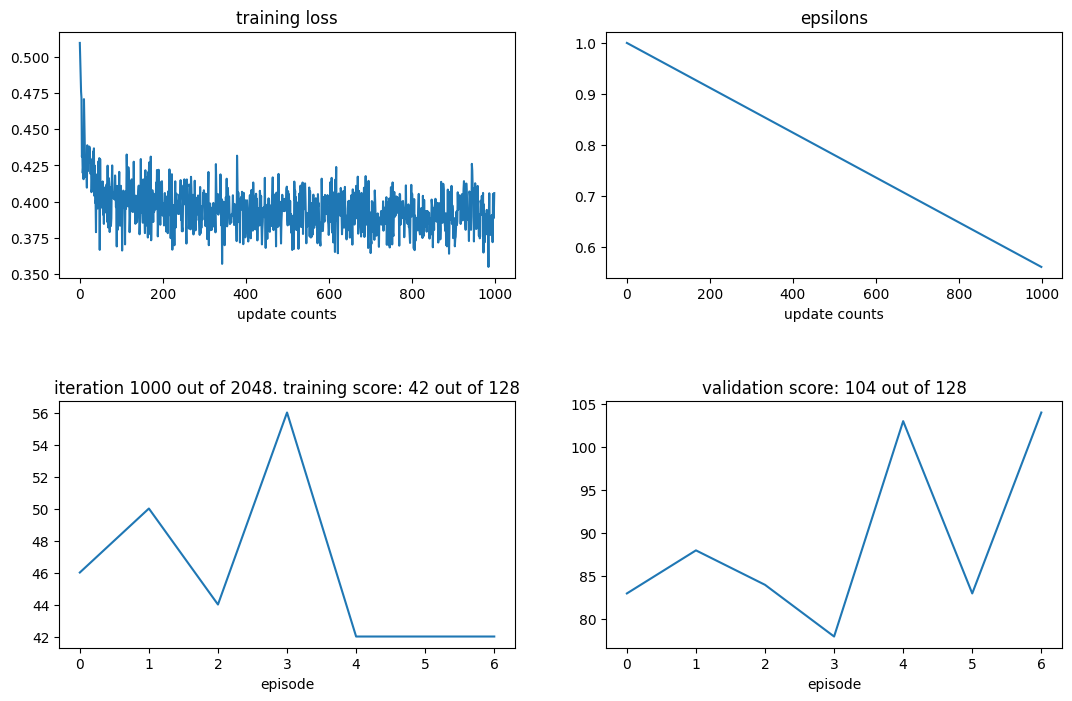

 49%|████▉     | 1005/2048 [43:02<44:40,  2.57s/it]


KeyboardInterrupt: 

In [1]:
import logging

logger = logging.getLogger()
logger.disabled = True

from agent import DQNAgent

for pretrain_semantic in [False, True]:
    for test_seed in [0, 1, 2, 3, 4]:
        # parameters
        all_params = {
            "env_str": "room_env:RoomEnv-v1",
            "max_epsilon": 1.0,
            "min_epsilon": 0.1,
            "epsilon_decay_until": 128 * 16,
            "gamma": 0.65,
            "capacity": {"episodic": 16, "semantic": 16, "short": 1},
            "nn_params": {
                "hidden_size": 64,
                "num_layers": 2,
                "embedding_dim": 32,
                "v1_params": {
                    "include_human": "sum",
                    "human_embedding_on_object_location": False,
                },
                "v2_params": None,
            },
            "num_iterations": 128 * 16,
            "replay_buffer_size": 1024 * 128,
            "warm_start": 1024 * 128,
            "batch_size": 1024,
            "target_update_rate": 10,
            "pretrain_semantic": pretrain_semantic,
            "run_validation": True,
            "run_test": True,
            "num_samples_for_results": 10,
            "train_seed": test_seed + 5,
            "plotting_interval": 10,
            "device": "cpu",
            "test_seed": test_seed,
            "ddqn": True,
            "dueling_dqn": True,
        }

        agent = DQNAgent(**all_params)
        agent.train()

In [4]:
from explicit_memory.utils import write_yaml

write_yaml(all_params, "train.yaml")

In [ ]:
import logging

logger = logging.getLogger()
logger.disabled = True

from tqdm.auto import tqdm

from agent import HandcraftedAgent

for policy in tqdm(["random", "episodic_only", "semantic_only"]):
    for test_seed in [0, 1, 2, 3, 4]:
        all_params = {
            "env_str": "room_env:RoomEnv-v1",
            "policy": policy,
            "num_samples_for_results": 10,
            "seed": test_seed,
        }
        if policy == "random":
            all_params["capacity"] = {"episodic": 16, "semantic": 16, "short": 1}
        elif policy == "episodic_only":
            all_params["capacity"] = {"episodic": 32, "semantic": 0, "short": 1}
        else:
            all_params["capacity"] = {"episodic": 0, "semantic": 32, "short": 1}

        all_params["seed"] = test_seed
        agent = HandcraftedAgent(**all_params)
        agent.test()

In [ ]:
from glob import glob
import yaml
import numpy as np

results = glob("./training_results/refactoring/episodic_only_agent/*/results.yaml")
scores = []
for file in results:
    with open(file, "r") as f:
        results = yaml.load(f, Loader=yaml.FullLoader)

    scores.append(results["test_score"]["mean"])
print(np.mean(scores), np.std(scores))

In [ ]:
from glob import glob
import yaml
import numpy as np

results = glob("./training_results/refactoring/semantic_only_agent/*/results.yaml")
scores = []
for file in results:
    with open(file, "r") as f:
        results = yaml.load(f, Loader=yaml.FullLoader)

    scores.append(results["test_score"]["mean"])
print(np.mean(scores), np.std(scores))

In [ ]:
from glob import glob
import yaml
import numpy as np

results = glob("./training_results/refactoring/random_agent/*/results.yaml")
scores = []
for file in results:
    with open(file, "r") as f:
        results = yaml.load(f, Loader=yaml.FullLoader)

    scores.append(results["test_score"]["mean"])
print(np.mean(scores), np.std(scores))